Считать данные 'Ключевые слова автора' и 'Ключевые слова указателя' с файла scopus_GEE.csv 

In [1]:
import csv

title_abstract_keywords = {}

with open("../scopus_GEE.csv", 'r') as file:
  csvreader = csv.DictReader(file)
  for row in csvreader:
    title = row['Название документа']
    abstract = row['Краткое описание']
    author_keywords = row['Ключевые слова автора']
    index_keywords = row['Ключевые слова указателя']

    title_abstract_keywords[title] = [abstract, author_keywords + index_keywords]

In [2]:
import os
import json

def save_data_to_json(title, data):
  directory = f'./'
  os.makedirs(directory, exist_ok=True)
  file_path = os.path.join(directory, f'{title}.json')
  with open(file_path, 'w', encoding='utf-8') as json_file:
      json.dump(data, json_file, ensure_ascii=False)  

In [3]:
import re

def is_word_in_sentence(word, sentence):
    word_pattern = r'\b{}\b'.format(re.escape(word))
    if re.search(word_pattern, sentence):
        return True
    return False

def get_sentence_with_word(word, text):
    sentences = text.split('.')

    sentences_with_word = []

    for sentence in sentences:
        if is_word_in_sentence(word, sentence):
            sentences_with_word.append(sentence)

    if len(sentences_with_word) > 0:
        return sentences_with_word[0].strip()
    return ""

In [4]:
word_context = {}

for title, abstract_keywords in title_abstract_keywords.items():
    abstract, keywords = abstract_keywords
    keywords_arr = keywords.split(';')
    abstract = abstract.lower()

    for word in keywords_arr:
        if len(word) == 0:
            continue

        word = word.lower()
        word = word.strip()

        if word in word_context:
            continue

        sentence = get_sentence_with_word(word, abstract)
        if sentence != "":
            word_context[word] = sentence
        else:
            word_context[word] = keywords

save_data_to_json("word_context",word_context)


In [5]:
import torch
from transformers import BertTokenizer, BertModel

model = BertModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def get_word_embedding(context, word):
    inputs = tokenizer(context, return_tensors="pt")
    input_ids = inputs["input_ids"]

    word_token_ids = [i for i, token_id in enumerate(input_ids[0]) if token_id == tokenizer.encode(word, add_special_tokens=False)[0]]

    if not word_token_ids:
        raise ValueError(f"'{word}' not found in '{sentence}'.")

    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state

    word_embeddings = [embeddings[0][position].numpy() for position in word_token_ids]
    
    return word_embeddings


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
word_embedding = {}
for word, context in word_context.items():
    embeddings = get_word_embedding(context, word)
    word_embedding[word] = embeddings[0]


In [9]:
word_list_embedding = {}
for word,embedding in word_embedding.items():
    word_list_embedding[word] = [str(val) for val in embedding]

save_data_to_json("word_embeddings",word_list_embedding)

In [7]:
# Parse word_embeddings.json
import json

word_embedding = {}
f = open('word_embeddings.json')
data = json.load(f)
for word, embedding in data.items():
    word_embedding[word] = [float(i) for i in embedding]


### Cosine Similarity approach

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import json
import numpy as np

seen = {}
similar_words = {}
threshold = 0.81
for word1, embedding1 in word_embedding.items():
    similar_words[word1] = [word1]
    for word2, embedding2 in word_embedding.items():
        if word1 != word2:
            similarity_score = 0
            if (word1,word2) in seen:
                similarity_score = seen[(word1,word2)]
            else:
                similarity_score = cosine_similarity([embedding1], [embedding2])[0][0]
                seen[(word1,word2)] = similarity_score
                seen[(word2,word1)] = similarity_score

            if similarity_score >= threshold:
                similar_words[word1].append(word2)
                


groups = []
visited = set()
for word, similar_list in similar_words.items():
    if word not in visited:
        group = similar_list
        visited.update(similar_list)
        groups.append(group)

grouped_data = []
for group in groups:
    grouped_data.append([', '.join(group)])

with open('grouped_json_file_'+str(threshold)+'.json', 'w') as grouped_json_file:
    json.dump(grouped_data, grouped_json_file)


In [1]:
import json

grouped_data = []
f = open('grouped_json_file_'+str(threshold)+'.json')
data = json.load(f)
for group in data:
    grouped_data.append(group[0])

In [4]:
data = grouped_data

def get_group_by_word(word):
  for words_str in data:
    words_arr = words_str.split(', ') 
    for i in range(len(words_arr)):
      if words_arr[i] == word:
        return words_str
  return ''

In [5]:
import csv
import pandas as pd

rows = []
with open("./scopus_GEE.csv", 'r') as file:
  csvreader = csv.DictReader(file)
  for row in csvreader:
    rows.append([row['Год'], row['Ключевые слова автора']])
    rows.append([row['Год'], row['Ключевые слова указателя']])



year_group_cnt = {}
'''
the format is:
year_group_cnt = {
    2023: {
        group1: 2,
        group2: 5,
        group3: 3
    }
}
'''
for row in rows:
  year, words_arr = row

  words = words_arr.split('; ')
  if year not in year_group_cnt:
    year_group_cnt[year] = {}

  for word in words:
    group = get_group_by_word(word.lower())
    
    if len(group) == 0:
      continue

    if group in year_group_cnt[year]:
      year_group_cnt[year][group] += 1
    else:
      year_group_cnt[year][group] = 1


new_data = {}
for year, year_data in year_group_cnt.items():
    for group, value in year_data.items():
        if group not in new_data:
            new_data[group] = {}
        new_data[group][year] = value


df = pd.DataFrame(new_data)
df = df.transpose()
df.reset_index(inplace=True)

df.to_csv('table_data_final.csv', index=False)




# Matplotlib graphs

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

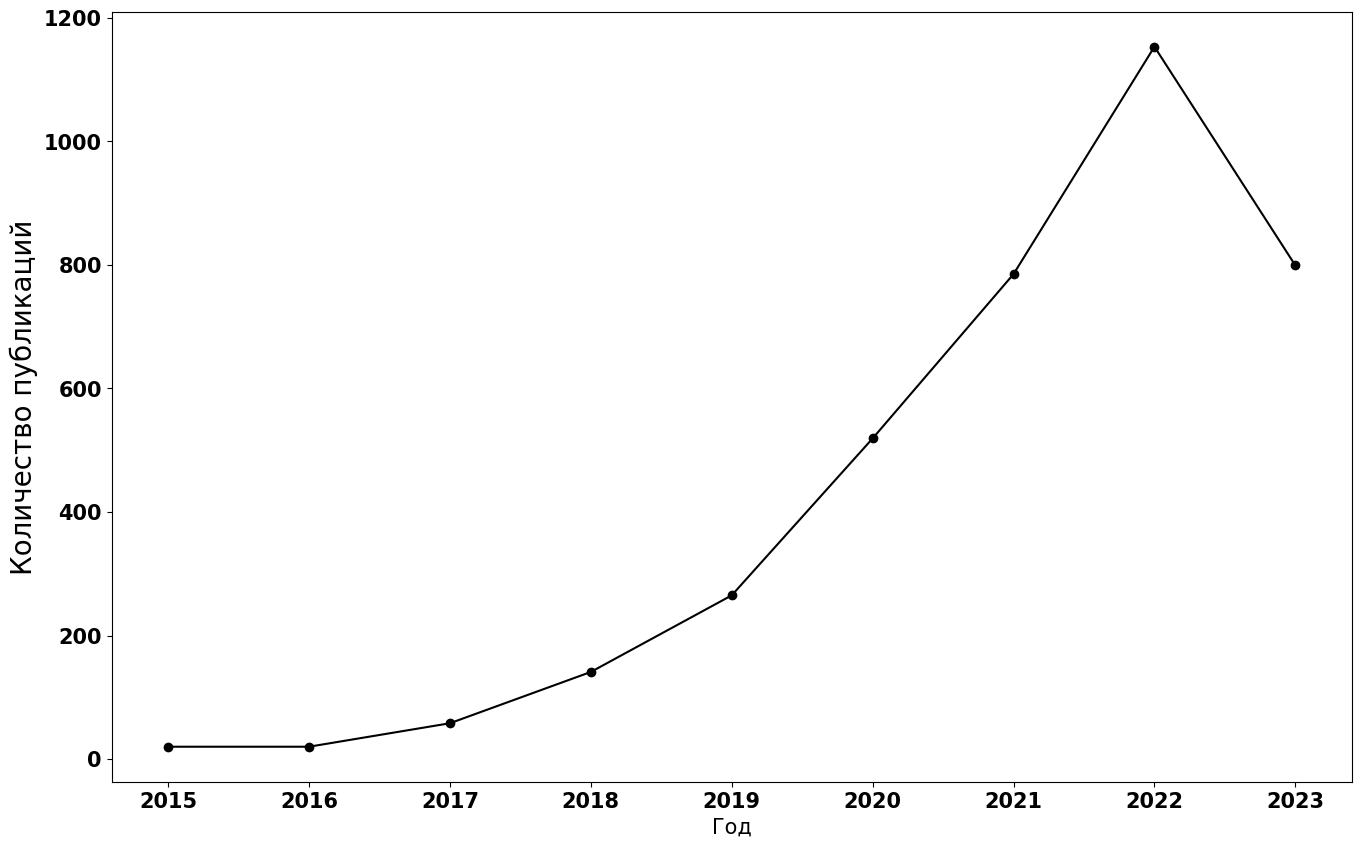

In [79]:
import matplotlib.pyplot as plt

import csv
import os
import json

years = []
citiations = []
with open("./scopus_GEE.csv", 'r') as file:
  csvreader = csv.DictReader(file)
  for row in csvreader:
    years.append(row['Год'])
    citiations.append(row['Цитирования'])

# years data
year_data = {}
for year in years:
  if year in year_data:
    year_data[year] += 1
  else:
    year_data[year] = 1

keys = list(year_data.keys())
keys.sort()
sorted_year_data = {i: year_data[i] for i in keys}

years = list(sorted_year_data.keys())[10:]
values = list(sorted_year_data.values())[10:]

font = {'size'   : 15}

plt.rc('font', **font)


fig, axs = plt.subplots(1, 1, figsize=(16, 10), sharey=True)
axs.set_xlabel('Год', fontsize=15)
axs.set_ylabel('Количество публикаций', fontsize=20)
axs.plot(years, values, '-ok')


Text(0, 0.5, 'Количество публикаций')

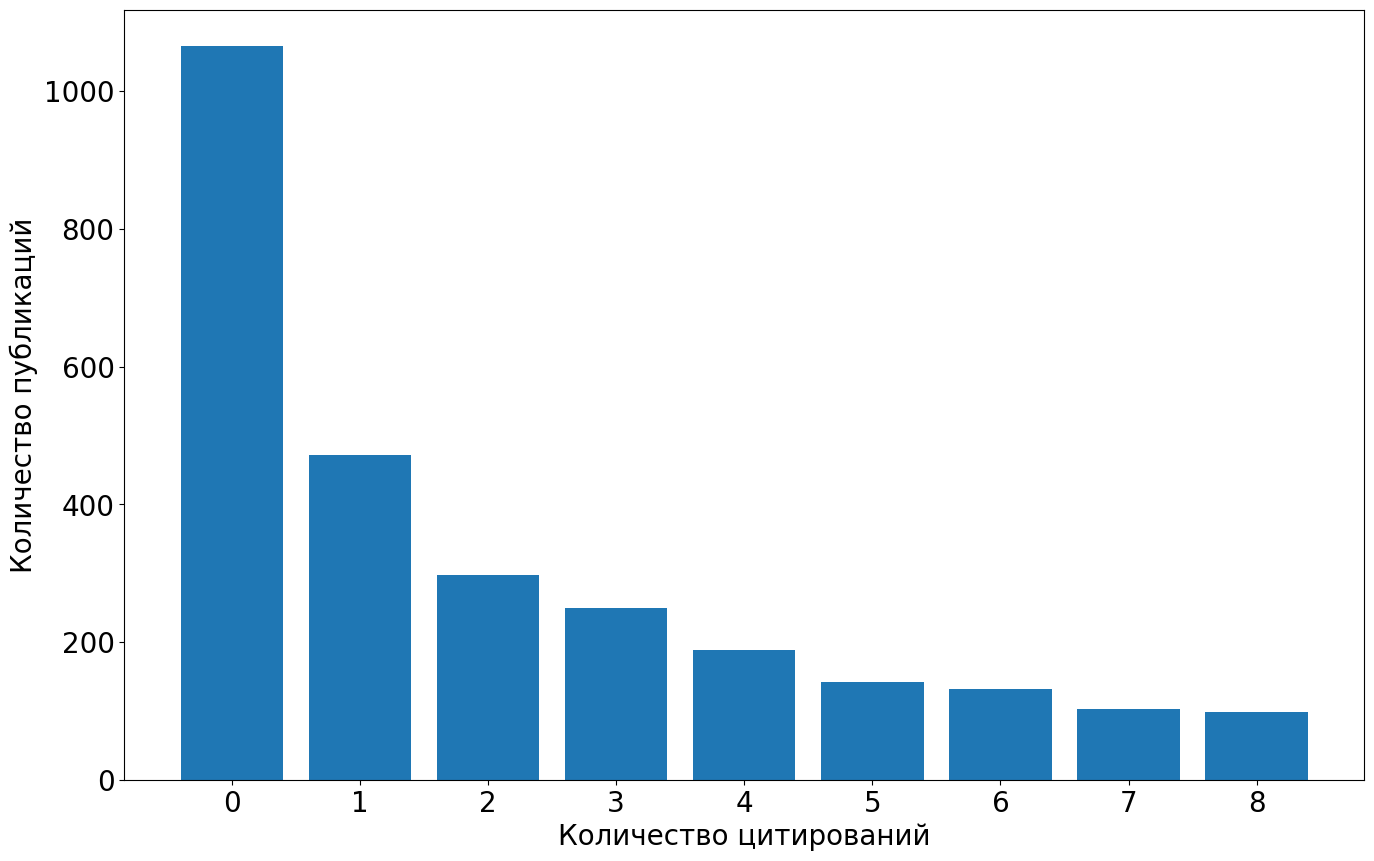

In [45]:
# citiations histogram
citiation_data = {}
for cit in citiations:
  if cit in citiation_data:
    citiation_data[cit] += 1
  else:
    citiation_data[cit] = 1
keys = sorted([int(i) for i in citiation_data.keys()][:9])

vals = []
for key in keys:
  vals.append(citiation_data[str(key)])


fig, axs = plt.subplots(1, 1, figsize=(16, 10))
axs.bar(keys, vals, align='center')
axs.set_xticks(keys)
axs.set_xlabel('Количество цитирований', fontsize=20)
axs.set_ylabel('Количество публикаций', fontsize=20)


In [ ]:
# Страны
import matplotlib.pyplot as plt

import csv

organizations = []
with open("./scopus_GEE.csv", 'r') as file:
  csvreader = csv.DictReader(file)
  for row in csvreader:
    organizations.append(row['Организации'])

countries = {}
for org in organizations:
  org_arr = org.split(',') 
  country = org_arr[-1]
  if country in countries:
    countries[country] += 1
  else:
    countries[country] = 1

ranking = sorted(countries.items(), key=lambda x: x[1], reverse=True)[:10]

keys = [i[0] for i in ranking]
vals = [i[1] for i in ranking]

font = {'size'   : 14}

plt.rc('font', **font)


fig, axs = plt.subplots(1, 1, figsize=(20, 10))
axs.bar(keys, vals, align='center')
axs.set_xticks(keys)
axs.set_xlabel('Страны', fontsize=20)
axs.set_ylabel('Количество публикаций', fontsize=20)



[2015 2016 2017 2018 2019 2020 2021 2022]
[20, 20, 58, 141, 265, 519, 785, 1153]


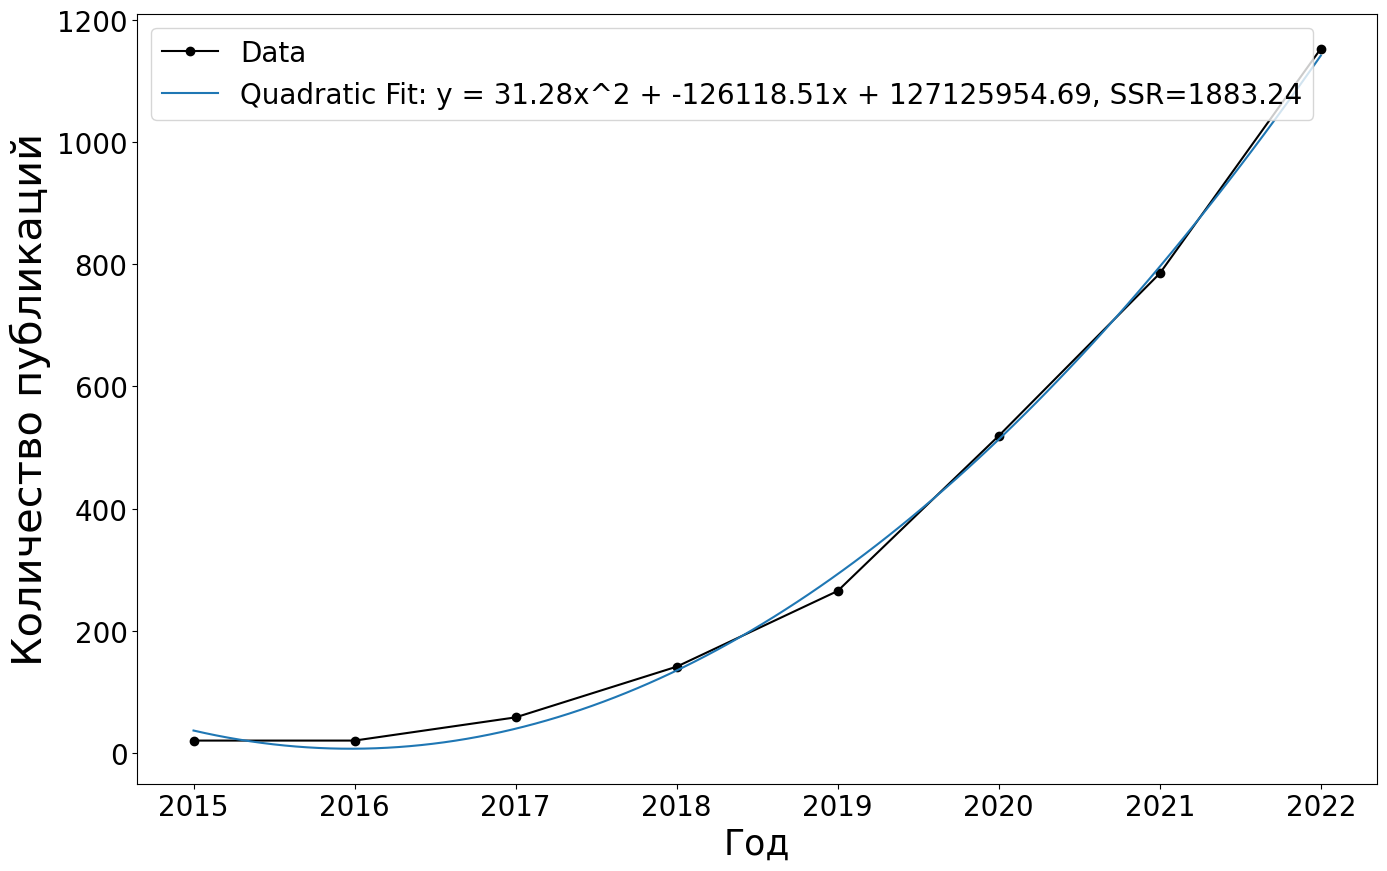

In [42]:
import matplotlib.pyplot as plt

import csv
from scipy.optimize import curve_fit

years = []
citiations = []
with open("./scopus_GEE.csv", 'r') as file:
  csvreader = csv.DictReader(file)
  for row in csvreader:
    years.append(row['Год'])
    citiations.append(row['Цитирования'])

year_data = {}
for year in years:
  if year in year_data:
    year_data[year] += 1
  else:
    year_data[year] = 1

keys = list(year_data.keys())
keys.sort()
sorted_year_data = {int(i): year_data[i] for i in keys}

years = list(sorted_year_data.keys())[10:-1]
values = list(sorted_year_data.values())[10:-1]

years = np.array(years)

print(years)
print(values)
def quadratic_model(x, a, b, c):
    return a * x**2 + b * x + c

params_quad, _ = curve_fit(quadratic_model, years, values)

x_fit = np.linspace(min(years), max(years), 100)

y_fit_quad = quadratic_model(x_fit, *params_quad)

residuals_quad = values - quadratic_model(years, *params_quad)
ssr_quad = np.sum(residuals_quad**2)

font = {'size'   : 20}

plt.rc('font', **font)

fig, axs = plt.subplots(1, 1, figsize=(16, 10), sharey=True)
axs.set_xlabel('Год', fontsize=25)
axs.set_ylabel('Количество публикаций', fontsize=30)
axs.plot(years, values, '-ok', label='Data')

plt.plot(x_fit, y_fit_quad, label=f'Quadratic Fit: y = {params_quad[0]:.2f}x^2 + {params_quad[1]:.2f}x + {params_quad[2]:.2f}, SSR={ssr_quad:.2f}')

axs.legend()


In [44]:
from sklearn.metrics import r2_score

r2_fit = r2_score(values, quadratic_model(years, *params_quad))

print(f"R-squared: {r2_fit:.2f}")


R-squared: 1.00


# Данные с ВЕГА

In [87]:
word_list_embedding = {}
for word,embedding in word_embedding.items():
    word_list_embedding[word] = [str(val) for val in embedding]

save_data_to_json("word_embeddings_vega",word_list_embedding)

In [88]:
from sklearn.metrics.pairwise import cosine_similarity
import json
import numpy as np

similar_words = {}
threshold = 0.81
for word1, embedding1 in word_embedding.items():
    similar_words[word1] = [word1]
    for word2, embedding2 in word_embedding.items():
        if word1 != word2:
            similarity_score = cosine_similarity([embedding1], [embedding2])[0][0]
            if similarity_score >= threshold:
                similar_words[word1].append(word2)

groups = []
visited = set()
for word, similar_list in similar_words.items():
    if word not in visited:
        group = similar_list
        visited.update(similar_list)
        groups.append(group)

grouped_data = []
for group in groups:
    grouped_data.append([', '.join(group)])

with open('grouped_json_vega_file_'+str(threshold)+'.json', 'w') as grouped_json_file:
    json.dump(grouped_data, grouped_json_file)


In [90]:
# Parse grouped_json_file_0.81.json
import json

grouped_data = []
f = open('grouped_json_vega_file_0.81.json')
data = json.load(f)
for group in data:
    grouped_data.append(group[0])

In [91]:
data = grouped_data

def get_group_by_word(word):
  for words_str in data:
    words_arr = words_str.split(', ') 
    for i in range(len(words_arr)):
      if words_arr[i] == word:
        return words_str
  return ''

In [ ]:
import csv
import pandas as pd

rows = []
for title, year in title_year.items():
    rows.append([year, title])


year_group_cnt = {}
'''
year_group_cnt = {
    2023: {
        group1: 2,
        group2: 5,
        group3: 3
    }
}
'''
for row in rows:
  year, words_arr = row

  # words = words_arr.split('; ')
  if year not in year_group_cnt:
    year_group_cnt[year] = {}

  # for word in words:
  print("words_arr.lower(): ",words_arr.lower())
  group = get_group_by_word(words_arr)
  print("group: ",group)
  if len(group) == 0:
    continue

  if group in year_group_cnt[year]:
    year_group_cnt[year][group] += 1
  else:
    year_group_cnt[year][group] = 1

print(year_group_cnt)
new_data = {}
for year, year_data in year_group_cnt.items():
    for group, value in year_data.items():
        if group not in new_data:
            new_data[group] = {}
        new_data[group][year] = value


df = pd.DataFrame(new_data)
df = df.transpose()
df.reset_index(inplace=True)

df.to_csv('table_data_vega_final.csv', index=False)

# New data

[2015 2016 2017 2018 2019 2020 2021 2022]
[141, 96, 132, 186, 131, 113, 141, 121]


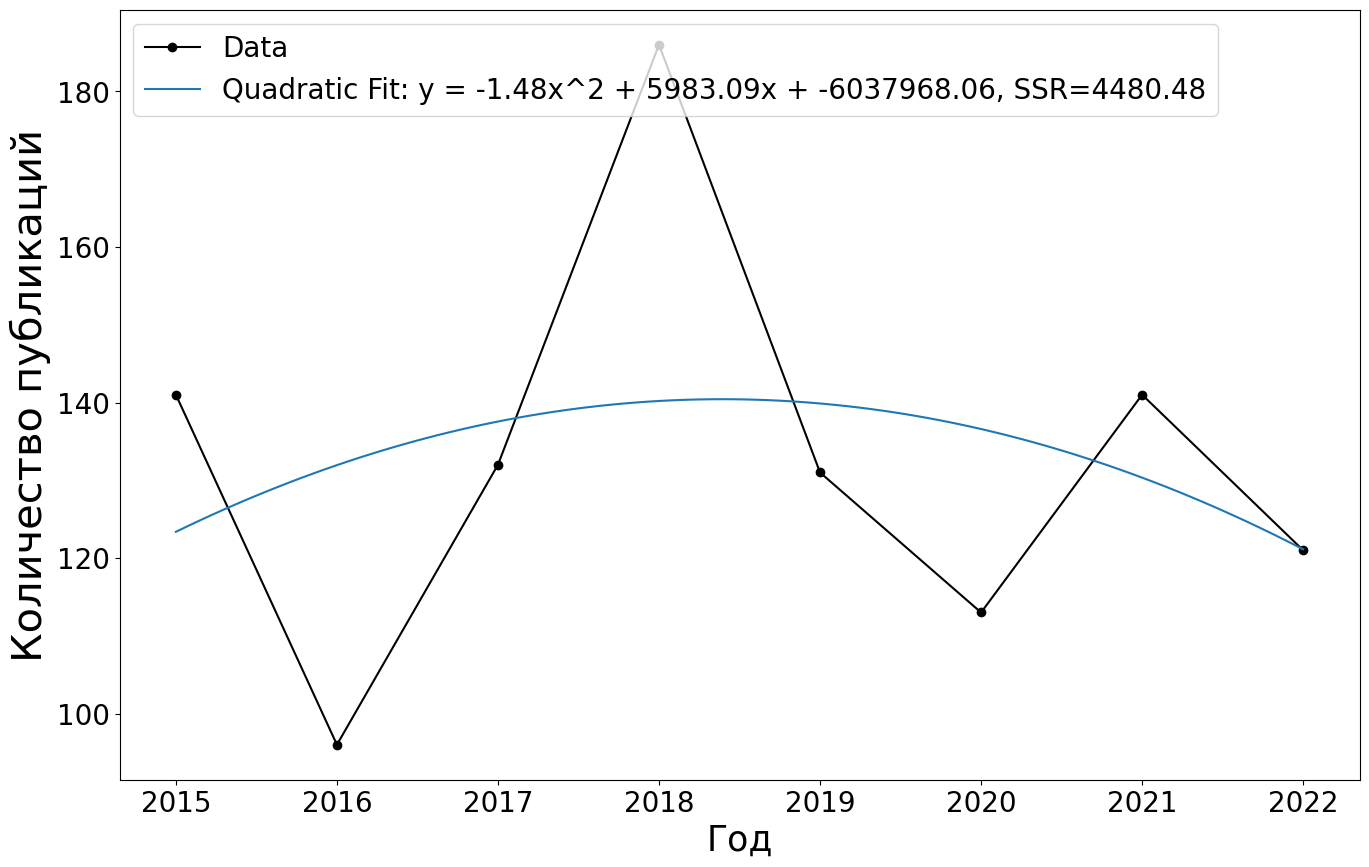

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

keys = list(years_all.keys())
keys.sort()
sorted_year_data = {int(i): years_all[i] for i in keys}

years = list(sorted_year_data.keys())
values = list(sorted_year_data.values())

years = np.array(years)

print(years)
print(values)
def quadratic_model(x, a, b, c):
    return a * x**2 + b * x + c

params_quad, _ = curve_fit(quadratic_model, years, values)

x_fit = np.linspace(min(years), max(years), 100)

y_fit_quad = quadratic_model(x_fit, *params_quad)

residuals_quad = values - quadratic_model(years, *params_quad)
ssr_quad = np.sum(residuals_quad**2)

font = {'size'   : 20}

plt.rc('font', **font)

fig, axs = plt.subplots(1, 1, figsize=(16, 10), sharey=True)
axs.set_xlabel('Год', fontsize=25)
axs.set_ylabel('Количество публикаций', fontsize=30)
axs.plot(years, values, '-ok', label='Data')

plt.plot(x_fit, y_fit_quad, label=f'Quadratic Fit: y = {params_quad[0]:.2f}x^2 + {params_quad[1]:.2f}x + {params_quad[2]:.2f}, SSR={ssr_quad:.2f}')

axs.legend(loc='upper left')


[2015 2016 2017 2018 2019 2020 2021 2022]
[26, 20, 22, 42, 37, 21, 22, 24]


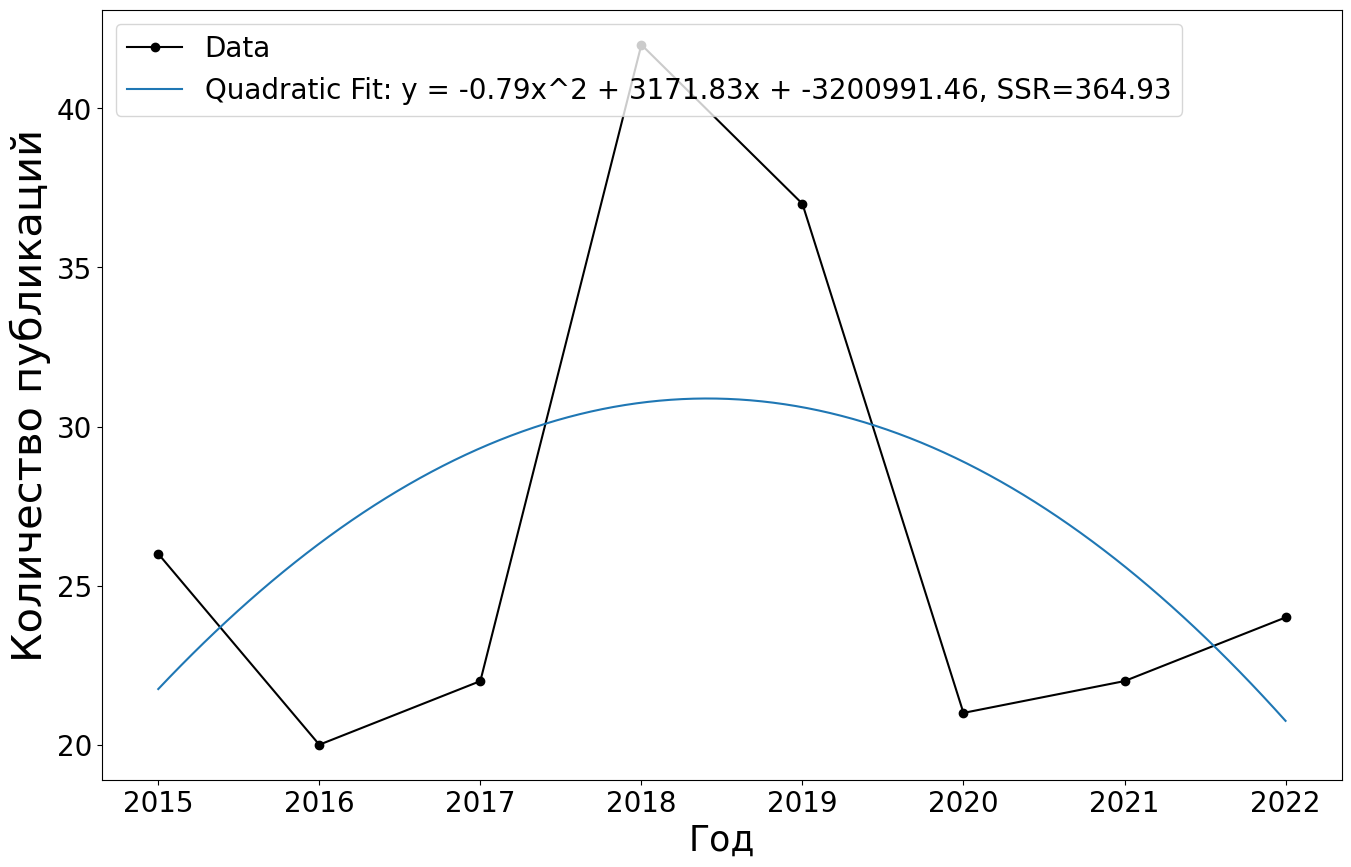

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

keys = list(years_gis.keys())
keys.sort()
sorted_year_data = {int(i): years_gis[i] for i in keys}

years = list(sorted_year_data.keys())
values = list(sorted_year_data.values())

years = np.array(years)

print(years)
print(values)
def quadratic_model(x, a, b, c):
    return a * x**2 + b * x + c

params_quad, _ = curve_fit(quadratic_model, years, values)

x_fit = np.linspace(min(years), max(years), 100)

y_fit_quad = quadratic_model(x_fit, *params_quad)

residuals_quad = values - quadratic_model(years, *params_quad)
ssr_quad = np.sum(residuals_quad**2)

font = {'size'   : 20}

plt.rc('font', **font)

fig, axs = plt.subplots(1, 1, figsize=(16, 10), sharey=True)
axs.set_xlabel('Год', fontsize=25)
axs.set_ylabel('Количество публикаций', fontsize=30)
axs.plot(years, values, '-ok', label='Data')

plt.plot(x_fit, y_fit_quad, label=f'Quadratic Fit: y = {params_quad[0]:.2f}x^2 + {params_quad[1]:.2f}x + {params_quad[2]:.2f}, SSR={ssr_quad:.2f}')

axs.legend(loc='upper left')

[2015 2016 2017 2018 2019 2020 2021 2022]
[79, 59, 70, 99, 63, 59, 73, 72]


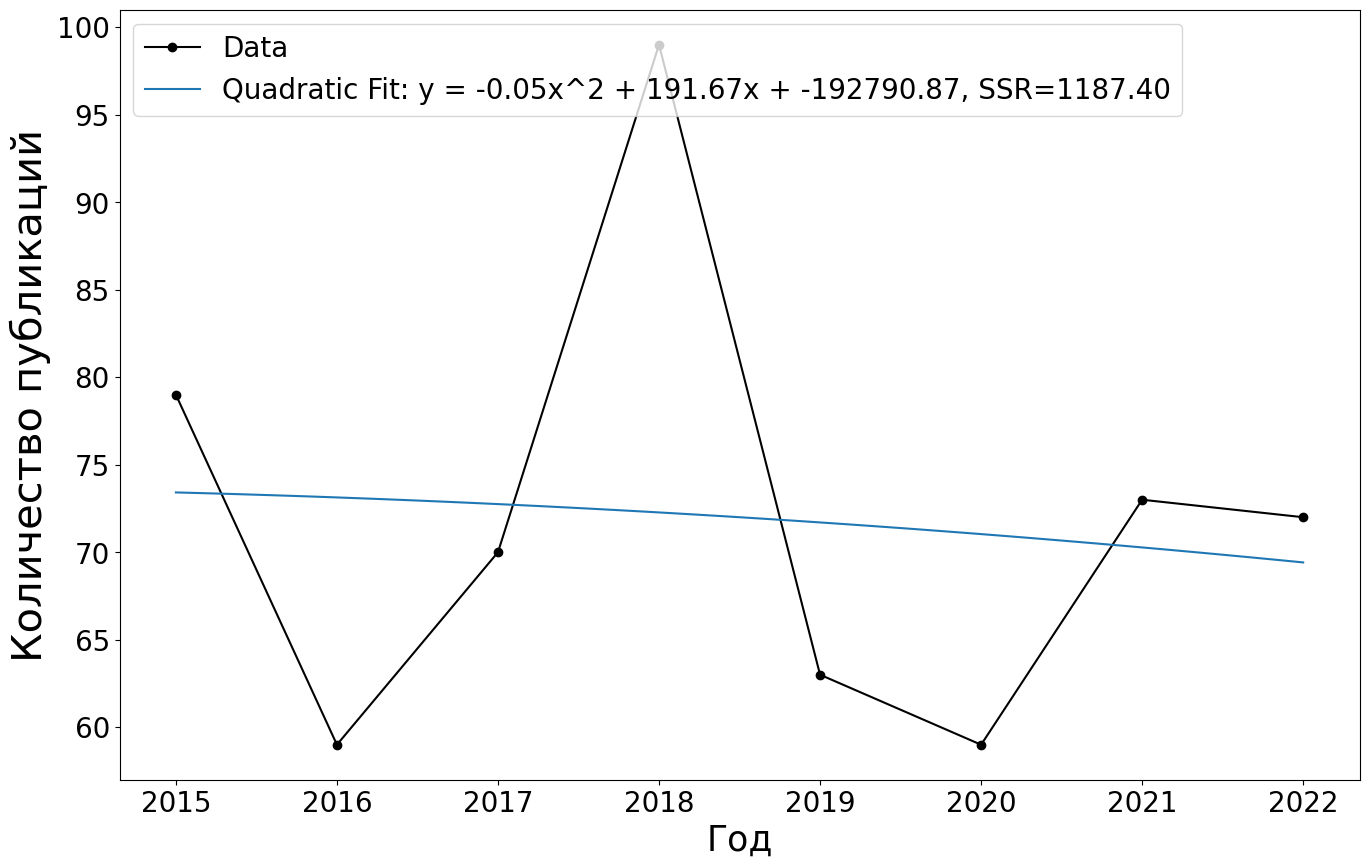

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

keys = list(years_sci.keys())
keys.sort()
sorted_year_data = {int(i): years_sci[i] for i in keys}

years = list(sorted_year_data.keys())
values = list(sorted_year_data.values())

years = np.array(years)

print(years)
print(values)
def quadratic_model(x, a, b, c):
    return a * x**2 + b * x + c

params_quad, _ = curve_fit(quadratic_model, years, values)

x_fit = np.linspace(min(years), max(years), 100)

y_fit_quad = quadratic_model(x_fit, *params_quad)

residuals_quad = values - quadratic_model(years, *params_quad)
ssr_quad = np.sum(residuals_quad**2)

font = {'size'   : 20}

plt.rc('font', **font)

fig, axs = plt.subplots(1, 1, figsize=(16, 10), sharey=True)
axs.set_xlabel('Год', fontsize=25)
axs.set_ylabel('Количество публикаций', fontsize=30)
axs.plot(years, values, '-ok', label='Data')

plt.plot(x_fit, y_fit_quad, label=f'Quadratic Fit: y = {params_quad[0]:.2f}x^2 + {params_quad[1]:.2f}x + {params_quad[2]:.2f}, SSR={ssr_quad:.2f}')

axs.legend(loc='upper left')


[2015 2016 2017 2018 2019 2020 2021 2022]
[36, 17, 40, 45, 31, 33, 46, 25]


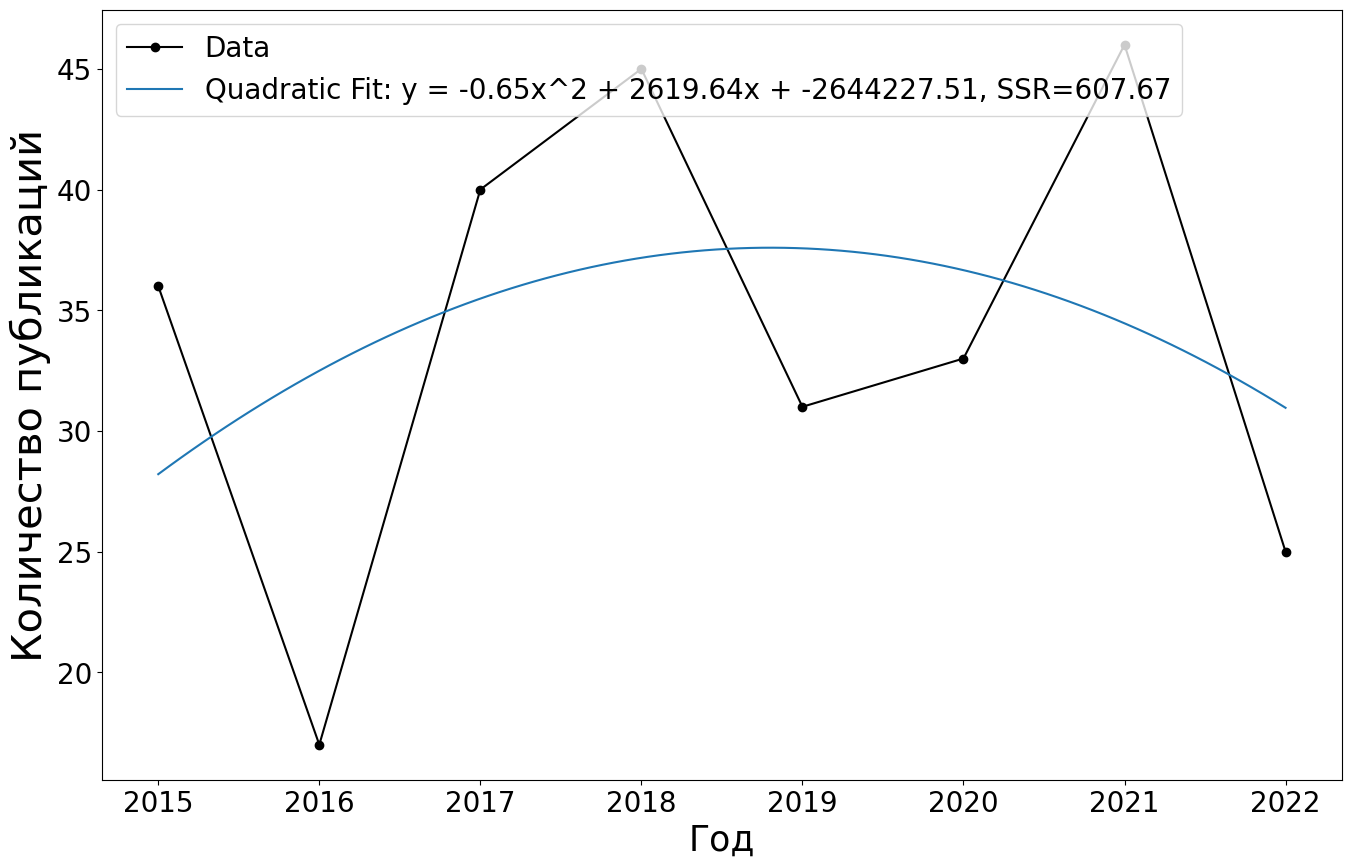

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

keys = list(years_pro.keys())
keys.sort()
sorted_year_data = {int(i): years_pro[i] for i in keys}

years = list(sorted_year_data.keys())
values = list(sorted_year_data.values())

years = np.array(years)

print(years)
print(values)
def quadratic_model(x, a, b, c):
    return a * x**2 + b * x + c

params_quad, _ = curve_fit(quadratic_model, years, values)

x_fit = np.linspace(min(years), max(years), 100)

y_fit_quad = quadratic_model(x_fit, *params_quad)

residuals_quad = values - quadratic_model(years, *params_quad)
ssr_quad = np.sum(residuals_quad**2)

font = {'size'   : 20}

plt.rc('font', **font)

fig, axs = plt.subplots(1, 1, figsize=(16, 10), sharey=True)
axs.set_xlabel('Год', fontsize=25)
axs.set_ylabel('Количество публикаций', fontsize=30)
axs.plot(years, values, '-ok', label='Data')

plt.plot(x_fit, y_fit_quad, label=f'Quadratic Fit: y = {params_quad[0]:.2f}x^2 + {params_quad[1]:.2f}x + {params_quad[2]:.2f}, SSR={ssr_quad:.2f}')

#axs.legend()
axs.legend(loc='upper left')


In [17]:
import json
for threshold, data in grouped_data.items():
    with open(f'vega_grouped_data_threshold.json', 'w') as grouped_json_file:
        json.dump(data, grouped_json_file)
